In [4]:
import numpy as np
import pandas as pd
from math import exp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

In [5]:
%matplotlib inline

In [5]:
def parametryTopologii():
    '''
    Funkcja zwracająca optymalizowane parametry topologii sieci
    
    '''
    
    fa = [1, 2, 3] #funkcja aktywacji
    lt = [0, 1] # współczynnik uczenia
    lr = list(range(1, 1001, 1)) # startowy współczynnik uczenia
    hl = list(range(1, 6)) # liczba warstw ukrytych
    nn = list(range(1, 129)) # liczba neuronów w warstwie
    parametry = {0:fa, 1:lt, 2:lr, 3:hl, 4:nn}

    return parametry

In [6]:
def parametryTopologii():
    '''
    Funkcja zwracająca optymalizowane parametry topologii sieci
    
    '''
    
    fa = [1, 2, 3] #funkcja aktywacji
    lt = [0, 1] # współczynnik uczenia
    lr = list(range(1, 1001, 1)) # startowy współczynnik uczenia
    hl = list(range(1, 6)) # liczba warstw ukrytych
    nn = list(range(1, 129)) # liczba neuronów w warstwie
    parametry = {0:fa, 1:lt, 2:lr, 3:hl, 4:nn}

    return parametry

In [7]:

def startowaPopulacja(liczebnosc_pop):
    '''
    Funkcja tworząca startową populacje
    
    Zwraca:
    populacja (dict) - słownik z listami chromosomow
    
    '''
    populacja = {}
    #liczebnosc_pop = 10

    for j in range(liczebnosc_pop):
        ch2 = np.ones(5, dtype=int)
        for i in range(5):
            ch2[i] = np.random.choice(parametryTopologii()[i])
        populacja[j] = ch2
    return populacja

In [8]:

def mutacja(chromosom):
    '''
    
    Funkcja mutacji - zmieniajaca losowo jeden z parametrow chromosomu
    Wybiera losowy gen i zastepuje jego wartość dowolną wartość dozwoloną dla tego genu
    
    Parametry:
    - chromosom (list) - wektor reprezentujacy chromosom
    
    Zwraca:
    - m_chromosom (list) - zmutowany chromosom
    
    '''
    
    # parametr który ma zostać zmutowany
    p = np.random.randint(0, len(chromosom))
    m_chromosom = chromosom.copy()
    pT = parametryTopologii()[p]
    pT.pop(pT.index(m_chromosom[p]))
    m_chromosom[p] = np.random.choice(pT)

    return m_chromosom

In [9]:

def siec(chromosom):
    '''
    
    Funkcja tworząca nową sieć na podstawie otrzymanego chromosomu
    Parametry:
     - chromosom
     
    Zwraca:
     - macierz - macierz błędu\trafności 
    
    '''
    f_aktywacji = {1:'logistic', 2:'tanh', 3:'relu'}
    wsp_uczenia = {0:'constant', 1:'invscaling'}
    warstwy = tuple(np.ones(chromosom[3], dtype=int)*chromosom[4])
    mlp = MLPClassifier(hidden_layer_sizes=warstwy, activation=f_aktywacji[chromosom[0]],\
                        learning_rate=wsp_uczenia[chromosom[1]], solver='sgd', learning_rate_init = 1/(2*chromosom[2])\
                        , random_state=42)
    
    mlp.fit(X_train_sc, Y_train)
    prognoza = mlp.predict(X_test_sc)
    macierz = confusion_matrix(Y_test, prognoza)

    return macierz
    

In [10]:
# macierz kosztu = [TP, FP, TN, FN]
def funkcjaZysku(k):
    '''
    Funkcja obliczajaca wartosci zysku danej sieci na podstawie macierzy kontyngencji składającej się z:
    TruePositive, FalsePositive, TrueNegative, FalseNegative
    
    Parametry:
    k (list) - lista zawierajaca liczbe wartosci każdej z czterech możliwych kombinacji klasyfikacji 
    
    Zwraca:
    koszt (float) - liczba rzeczywista określająca zysk związany z danym efektem klasyfikacji
    
    '''
    
    cost_matrix = np.array([19.9, -0.1, 0, -20.1])
    zysk = np.round(np.dot(k, cost_matrix), 5) 

    return zysk

In [11]:
def selekcja(populacja, przystosowanie):
    '''
    Funkcja selekcji - wybierająca chromosomy do krzyżowania
    
    Parametry:
    - populacja (dict) - słownik z aktualną populacją
    - przystosowanie (dict) - słownik z wartościami funkcji przystosowania dla każdego chromosomu w populacji
    
    Zwraca:
    - nowa_populacja (dict) - słownik z nową populacją
    
    '''
    fitness = przystosowanie
    mmsc = MinMaxScaler(feature_range=(0,100)).fit_transform(fitness.reshape(-1, 1))
    s = sum(mmsc)
    mmsc = mmsc/s*100
    f_total = []
    for m, i in enumerate(mmsc):
        for j in range(int(i)):
            f_total.append(m)
    parents_pool = np.copy(f_total)
    nowa_populacja = {}
    for j in range(len(populacja)):
        # wybieranie losowych rodziców metodą ruletki
        father = np.random.choice(parents_pool)
        # drugi rodzic nie może być taki sam jak pierwszy
        mother = parents_pool[parents_pool!=father]
        # jeśli pozostał tylko jeden rodzic w populacji to muszę go wybrać
        if len(mother) == 0:
            mother = father
        else:
            mother = np.random.choice(mother)
        father = populacja[father]
        mother = populacja[mother]
        c = np.random.randint(1, len(father))
        child = np.concatenate([father[:c], mother[c:]])
        # mutacja
        mutationPr = 0.25
        wsp_mutacji = mutationPr/np.exp(i/10) 
        m = np.random.random()
        if m < wsp_mutacji:
            child = mutacja(child)
        nowa_populacja[j] = child
    
    return nowa_populacja

Miejsce na zbiór danych po przekształceniach 

In [6]:
dataset = pd.read_csv('msc_dataset.txt',  sep="\t")
df = dataset[['TRX_aff_L12M_COL_PTS', 'TRX_aff_L12M_PUR_AMT', 'TRX_aff_L3M_BASE_PTS',
       'TRX_aff_L3M_COL_CNT', 'TRX_aff_L3M_PROMO_PTS', 'TRX_aff_L3M_PUR_AMT',
       'ACCT_BAL_MOD_CNT', 'ACCT_TOT_COL_AMT', 'ACCT_UNBLOCKED_POINTS',
       'TIME_FROM_ENRL', 'TIME_FROM_FIRST_DT', 'TIME_FROM_LAST_DT',
       'CARDA_PAYM_CNT', 'ACCT_PTS_EXPIRED', 'ACCT_PTS_TO_EXPIRE',
       'CUST_GFK_POPULATION', 'CUST_GFK_HOUSEHOLDS', 'CUST_HH_SIZE',
       'CUST_AGE', 'CUST_GENDER', 'CUST_CA_AAA_FLG', 'CUST_CA_BBB_FLG',
       'CUST_CA_CCC_FLG', 'CUST_CA_BBB_KM_CNT', 'CUST_CA_AAA_KM_CNT',
       'CUST_CA_CCC_KM_CNT', 'WEB_ALL_UNQ_SES_CNT_L2W',
       'WEB_ALL_TIME_SPEND_L2W', 'WEB_ALL_UNQ_SES_CNT_L4W',
       'WEB_ALL_TIME_SPEND_L4W', 'WEB_AFF_UNQ_SES_CNT_L2W',
       'WEB_AFF_TIME_SPEND_L2W', 'WEB_AFF_UNQ_SES_CNT_L4W',
       'WEB_AFF_TIME_SPEND_L4W', 'WEB_HIS_UNQ_SES_CNT_L2W',
       'WEB_HIS_TIME_SPEND_L2W', 'WEB_HIS_UNQ_SES_CNT_L4W',
       'WEB_HIS_TIME_SPEND_L4W', 'WEB_OCC_UNQ_SES_CNT_L2W',
       'WEB_OCC_TIME_SPEND_L2W', 'WEB_OCC_UNQ_SES_CNT_L4W',
       'WEB_OCC_TIME_SPEND_L4W', 'WEB_REW_UNQ_SES_CNT_L2W',
       'WEB_REW_TIME_SPEND_L2W', 'WEB_REW_UNQ_SES_CNT_L4W',
       'WEB_REW_TIME_SPEND_L4W', 'WEB_ALL_UNQ_SES_CNT_L3M',
       'WEB_ALL_TIME_SPEND_L3M', 'WEB_ALL_UNQ_SES_CNT_L6M',
       'WEB_ALL_TIME_SPEND_L6M', 'WEB_ALL_UNQ_SES_CNT_L12M',
       'WEB_ALL_TIME_SPEND_L12M', 'WEB_AFF_UNQ_SES_CNT_L3M',
       'WEB_AFF_TIME_SPEND_L3M', 'WEB_AFF_UNQ_SES_CNT_L6M',
       'WEB_AFF_TIME_SPEND_L6M', 'WEB_AFF_UNQ_SES_CNT_L12M',
       'WEB_AFF_TIME_SPEND_L12M', 'WEB_HIS_UNQ_SES_CNT_L3M',
       'WEB_HIS_TIME_SPEND_L3M', 'WEB_HIS_UNQ_SES_CNT_L6M',
       'WEB_HIS_TIME_SPEND_L6M', 'WEB_HIS_UNQ_SES_CNT_L12M',
       'WEB_HIS_TIME_SPEND_L12M', 'WEB_OCC_UNQ_SES_CNT_L3M',
       'WEB_OCC_TIME_SPEND_L3M', 'WEB_OCC_UNQ_SES_CNT_L6M',
       'WEB_OCC_TIME_SPEND_L6M', 'WEB_OCC_UNQ_SES_CNT_L12M',
       'WEB_OCC_TIME_SPEND_L12M', 'WEB_REW_UNQ_SES_CNT_L3M',
       'WEB_REW_TIME_SPEND_L3M', 'WEB_REW_UNQ_SES_CNT_L6M',
       'WEB_REW_TIME_SPEND_L6M', 'WEB_REW_UNQ_SES_CNT_L12M',
       'WEB_REW_TIME_SPEND_L12M', 'event']]


In [7]:
X = df[['TRX_aff_L12M_COL_PTS', 'TRX_aff_L12M_PUR_AMT', 'TRX_aff_L3M_BASE_PTS',
       'TRX_aff_L3M_COL_CNT', 'TRX_aff_L3M_PROMO_PTS', 'TRX_aff_L3M_PUR_AMT',
       'ACCT_BAL_MOD_CNT', 'ACCT_TOT_COL_AMT', 'ACCT_UNBLOCKED_POINTS',
       'TIME_FROM_ENRL', 'TIME_FROM_FIRST_DT', 'TIME_FROM_LAST_DT',
       'CARDA_PAYM_CNT', 'ACCT_PTS_EXPIRED', 'ACCT_PTS_TO_EXPIRE',
       'CUST_GFK_POPULATION', 'CUST_GFK_HOUSEHOLDS', 'CUST_HH_SIZE',
       'CUST_AGE', 'CUST_GENDER', 'CUST_CA_AAA_FLG', 'CUST_CA_BBB_FLG',
       'CUST_CA_CCC_FLG', 'CUST_CA_BBB_KM_CNT', 'CUST_CA_AAA_KM_CNT',
       'CUST_CA_CCC_KM_CNT', 'WEB_ALL_UNQ_SES_CNT_L2W',
       'WEB_ALL_TIME_SPEND_L2W', 'WEB_ALL_UNQ_SES_CNT_L4W',
       'WEB_ALL_TIME_SPEND_L4W', 'WEB_AFF_UNQ_SES_CNT_L2W',
       'WEB_AFF_TIME_SPEND_L2W', 'WEB_AFF_UNQ_SES_CNT_L4W',
       'WEB_AFF_TIME_SPEND_L4W', 'WEB_HIS_UNQ_SES_CNT_L2W',
       'WEB_HIS_TIME_SPEND_L2W', 'WEB_HIS_UNQ_SES_CNT_L4W',
       'WEB_HIS_TIME_SPEND_L4W', 'WEB_OCC_UNQ_SES_CNT_L2W',
       'WEB_OCC_TIME_SPEND_L2W', 'WEB_OCC_UNQ_SES_CNT_L4W',
       'WEB_OCC_TIME_SPEND_L4W', 'WEB_REW_UNQ_SES_CNT_L2W',
       'WEB_REW_TIME_SPEND_L2W', 'WEB_REW_UNQ_SES_CNT_L4W',
       'WEB_REW_TIME_SPEND_L4W', 'WEB_ALL_UNQ_SES_CNT_L3M',
       'WEB_ALL_TIME_SPEND_L3M', 'WEB_ALL_UNQ_SES_CNT_L6M',
       'WEB_ALL_TIME_SPEND_L6M', 'WEB_ALL_UNQ_SES_CNT_L12M',
       'WEB_ALL_TIME_SPEND_L12M', 'WEB_AFF_UNQ_SES_CNT_L3M',
       'WEB_AFF_TIME_SPEND_L3M', 'WEB_AFF_UNQ_SES_CNT_L6M',
       'WEB_AFF_TIME_SPEND_L6M', 'WEB_AFF_UNQ_SES_CNT_L12M',
       'WEB_AFF_TIME_SPEND_L12M', 'WEB_HIS_UNQ_SES_CNT_L3M',
       'WEB_HIS_TIME_SPEND_L3M', 'WEB_HIS_UNQ_SES_CNT_L6M',
       'WEB_HIS_TIME_SPEND_L6M', 'WEB_HIS_UNQ_SES_CNT_L12M',
       'WEB_HIS_TIME_SPEND_L12M', 'WEB_OCC_UNQ_SES_CNT_L3M',
       'WEB_OCC_TIME_SPEND_L3M', 'WEB_OCC_UNQ_SES_CNT_L6M',
       'WEB_OCC_TIME_SPEND_L6M', 'WEB_OCC_UNQ_SES_CNT_L12M',
       'WEB_OCC_TIME_SPEND_L12M', 'WEB_REW_UNQ_SES_CNT_L3M',
       'WEB_REW_TIME_SPEND_L3M', 'WEB_REW_UNQ_SES_CNT_L6M',
       'WEB_REW_TIME_SPEND_L6M', 'WEB_REW_UNQ_SES_CNT_L12M',
       'WEB_REW_TIME_SPEND_L12M']]
Y = df['event']


In [8]:
X['CUST_CA_AAA_FLG'] = df.CUST_CA_AAA_FLG.map({'Y' : 1, 'N' : 0})
X['CUST_CA_BBB_FLG'] = df.CUST_CA_BBB_FLG.map({'Y' : 1, 'N' : 0})
X['CUST_CA_CCC_FLG'] = df.CUST_CA_CCC_FLG.map({'Y' : 1, 'N' : 0})

C:\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Apps\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/s

In [9]:
from sklearn.model_selection import train_test_split 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

In [10]:
len(X_train), len(X_test), len(Y_train), len(Y_test)

(169704, 56568, 169704, 56568)

Over-Sampling

In [29]:
from imblearn import over_sampling

In [30]:
adasyn = over_sampling.ADASYN(ratio=0.3, random_state=42)
X_resampled, Y_resampled = adasyn.fit_sample(X_train, Y_train)

C:\Apps\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [39]:
len(X_resampled), len(Y_resampled)

(219234, 219234)

Under-sampling

In [2]:
from imblearn import under_sampling

In [11]:
rus = under_sampling.RandomUnderSampler(ratio=0.3, random_state=42)
X_resampled2, Y_resampled2 = rus.fit_sample(X_train, Y_train)
len(X_resampled2) , len(Y_resampled2)

C:\Apps\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


(5746, 5746)

Standaryzacja

In [1]:
from sklearn.preprocessing import StandardScaler

In [12]:
X_resampled2_sc = StandardScaler().fit(X_resampled2).transform(X_resampled2)
X_test_sc = StandardScaler().fit(X_test).transform(X_test)

In [13]:
X_train_sc = X_resampled2_sc.copy()
Y_train = Y_resampled2.copy()

In [14]:
len(Y_train[Y_train==1])


1326

In [15]:
len(Y_test)

56568

In [16]:
from time import time

In [24]:
# Główna część wykonująca 
t = time()
# liczba iteracji algorytmu 
generations = 10

# liczba chromosomów w populacji - liczba różnych topologii 
liczebnosc_pop = 10

# wartości funkcji przystosowania dla poszczególnych iteracji
f_fit = {}

average_fitness = np.zeros(liczebnosc_pop)
maximum_fitness = np.zeros(liczebnosc_pop)
minimum_fitness = np.zeros(liczebnosc_pop)

# zbior populacji
zb_pop = {}
klasyfikacja = {}
populacja = startowaPopulacja(liczebnosc_pop)
czas_treningu = {}
czas_selekcji = {}
for i in range(generations):
    zb_pop[i] = populacja
    f_fit[i] = np.zeros(liczebnosc_pop)
    klasyfikacja[i] = {}
    fitness = np.zeros(len(populacja))
    for p in range(len(populacja)):
        y = siec(populacja[p])
        # wektor w przechowuje liczby: TP, FP, TN, FN
        w = np.array([y[1][1], y[0][1], y[0][0], y[1][0]])
        fitness[p] = funkcjaZysku(w)
        klasyfikacja[i][p] = y
    f_fit[i] = fitness
    average_fitness[i] = np.mean(fitness)
    maximum_fitness[i] = np.max(fitness)
    minimum_fitness[i] = np.min(fitness)
    if minimum_fitness[i] == maximum_fitness[i]:
        print('Najmniejsza i największa wartość funkcji przystosowania są takie same.')
        print('Osiągnięto minimum lokalne.')
        print('Iteracja nr {}'.format(i+1))
        break
    #nowa_populacja = {}
    new_pop = selekcja(populacja, fitness)
    populacja = new_pop.copy()
print(time() - t)

C:\Apps\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


4802.884230852127


In [25]:
klasyfikacja

{0: {0: array([[56122,     0],
         [  446,     0]], dtype=int64), 1: array([[56122,     0],
         [  446,     0]], dtype=int64), 2: array([[47175,  8947],
         [  282,   164]], dtype=int64), 3: array([[45290, 10832],
         [   60,   386]], dtype=int64), 4: array([[56122,     0],
         [  446,     0]], dtype=int64), 5: array([[56122,     0],
         [  446,     0]], dtype=int64), 6: array([[56122,     0],
         [  446,     0]], dtype=int64), 7: array([[55166,   956],
         [  357,    89]], dtype=int64), 8: array([[56122,     0],
         [  446,     0]], dtype=int64), 9: array([[55752,   370],
         [  405,    41]], dtype=int64)}, 1: {0: array([[46162,  9960],
         [   62,   384]], dtype=int64), 1: array([[46317,  9805],
         [   59,   387]], dtype=int64), 2: array([[54243,  1879],
         [  300,   146]], dtype=int64), 3: array([[56122,     0],
         [  446,     0]], dtype=int64), 4: array([[54994,  1128],
         [  398,    48]], dtype=int64), 

In [26]:
f_fit

{0: array([-8964.6, -8964.6, -3299.3,  5392.2, -8964.6, -8964.6, -8964.6,
        -5500.2, -8964.6, -7361.6]),
 1: array([ 5399.4,  5534.9, -3312.5, -8964.6, -7157.4, -4114. ,  5307.3,
        -3902.9,  5040.5,  5514.1]),
 2: array([ 5310. ,  5550.8,  5385.5,  5446.4,  5185.6,  5321. ,  5672.6,
        -8398.2,  5377.1,  5450.3]),
 3: array([ 5589.1,  5591.3,  5419.7,  5279.3,  5006.2,  4981.6,  5564. ,
         5134.6,  5364.3,  5210.8]),
 4: array([-8964.6,  5342.5,  5456.2,  4924.9,  5315.3,  5454.7, -6876.9,
         5169.7,  5206.6, -6275.6]),
 5: array([ 5466. ,  5161. ,  5473.4,  5265.6,  4958.6,  5025.3,  5641.6,
         5733.6,  5323.7,  5354.1]),
 6: array([ 5344.4,  4625.1,  5109.7,  5599. ,  5238.6,  5166.8,  5484.2,
         5176. ,  5226.6,  5425.5]),
 7: array([ 5113.8, -3236.8,  5448.8,  5552.9,  5538.7,  4835.9,  5420.2,
         5593.5,  5424.7,  5287.3]),
 8: array([ 5580.8,  5316.7,  5214.1,  4793.5,  5735.3,  5387.9,  5231. ,
         5479.4,  5558.7,  5601. ]),
 

In [32]:
zb_pop

{0: {0: array([  1,   0, 985,   4,  21]),
  1: array([  1,   0, 970,   3,  54]),
  2: array([  3,   1, 753,   3,  81]),
  3: array([  3,   0, 392,   2,  22]),
  4: array([  1,   1, 895,   3,  11]),
  5: array([  1,   0, 469,   5,  90]),
  6: array([  1,   0, 512,   3,  98]),
  7: array([  3,   1, 711,   3,  44]),
  8: array([  1,   1, 126,   4, 103]),
  9: array([  3,   1, 335,   4, 114])},
 1: {0: array([  3,   0, 711,   3,  44]),
  1: array([  3,   0, 753,   3,  81]),
  2: array([  3,   1, 711,   3, 114]),
  3: array([  1,   0, 392,   3,  44]),
  4: array([  3,   1, 753,   3,  22]),
  5: array([  3,   1, 711,   3,  44]),
  6: array([  3,   0, 392,   3,  81]),
  7: array([  3,   1, 711,   3,  81]),
  8: array([  3,   0, 392,   2,  81]),
  9: array([  3,   0, 753,   3,  22])},
 2: {0: array([  3,   0, 753,   3,  81]),
  1: array([  3,   0, 753,   3,  81]),
  2: array([  3,   0, 753,   3,  81]),
  3: array([  3,   0, 753,   3,  22]),
  4: array([  3,   0, 392,   2,  22]),
  5: array([  

In [30]:
maximum_fitness

array([ 5392.2,  5534.9,  5672.6,  5591.3,  5456.2,  5733.6,  5599. ,
        5593.5,  5735.3,  5767.7])

In [28]:
average_fitness

array([-6455.65,   -65.52,  4030.11,  5314.09,  1475.28,  5340.29,
        5239.59,  4497.9 ,  5389.84,  5436.58])

In [29]:
minimum_fitness

array([-8964.6, -8964.6, -8398.2,  4981.6, -8964.6,  4958.6,  4625.1,
       -3236.8,  4793.5,  5078.8])

In [185]:
klasyfikacja[9][0]

array([[45445, 10677],
       [   51,   395]], dtype=int64)

In [187]:
zb_pop[9][0]

array([  3,   0, 392,   3,  22])

In [186]:
395/(446)

0.8856502242152466

In [ ]:
[45445, 10677],
         [   51,   395]

In [31]:
395/446

0.8856502242152466

In [136]:
sp = startowaPopulacja(liczebnosc_pop)
sp

{0: array([  1,   0, 365,   2, 125]),
 1: array([ 3,  1, 38,  3, 40]),
 2: array([  1,   0, 403,   5,  84]),
 3: array([  2,   1, 671,   3,  58]),
 4: array([  3,   1, 984,   3,  34]),
 5: array([  1,   0, 643,   1,  78]),
 6: array([  1,   1, 622,   5, 126]),
 7: array([ 3,  0, 25,  1, 22]),
 8: array([  2,   0, 912,   5,  89]),
 9: array([  2,   0, 265,   5, 126])}

In [137]:
y = siec(sp[0])

In [138]:
y

array([[45631, 10491],
       [  118,   328]], dtype=int64)

In [125]:
403*19.9 -20.1*43 - 11432*0.1

6012.2

In [129]:
(403*19.9 -20.1*43 - 11432*0.1) / (446*19.9)

0.677400455190752

In [127]:
403/446

0.9035874439461884

In [119]:
11000*0.1

1100.0

Modele odniesienia

In [17]:
from sklearn.linear_model import LogisticRegression as LR

In [20]:
from sklearn.metrics import r2_score

In [18]:
linreg = LR(C=1, random_state=42)
linreg.fit(X_train_sc, Y_train)
pred = linreg.predict(X_test_sc)
print(confusion_matrix(Y_test, pred))

[[49501  6621]
 [  109   337]]


In [28]:
print(confusion_matrix(Y_test, pred))

[[49501  6621]
 [  109   337]]


In [21]:
r2_score(Y_test, pred)

-14.209603421629657

In [65]:
337/446

0.7556053811659192

In [29]:
y_log = confusion_matrix(Y_test, pred)
w_log = np.array([y_log[1][1], y_log[0][1], y_log[0][0], y_log[1][0]])
fitness_log = funkcjaZysku(w_log)
fitness_log

3853.3000000000002

In [75]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       1.00      0.88      0.94     56122
          1       0.05      0.76      0.09       446

avg / total       0.99      0.88      0.93     56568



In [103]:
3853/8875

0.43414084507042255

In [73]:
5768-3853

1915

In [146]:
(8875 - 6012)/(8875 - 3716.8)

0.5550385793493855

In [145]:
446*19.9

8875.4

In [2]:
5768/3853

1.497015312743317

In [36]:
for i in range(1, 10):
    wsp_m = 0.25/np.exp(i/10)
    print(wsp_m)

0.226209354509
0.204682688269
0.18520455517
0.167580011509
0.151632664928
0.137202909024
0.124146325948
0.112332241029
0.101642414935


In [73]:
y = list(range(1,10))
wsp_m = []
em = []
y2 = []
for i in range(1, 10):
    y2.append(i/10) 
    em.append(np.exp(i/10))
    wsp_m.append(0.25/np.exp(i/20))



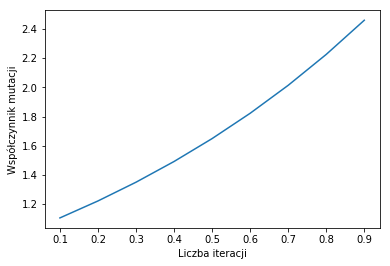

In [74]:
plt.plot(y2, em)
plt.xlabel('Liczba iteracji')
plt.ylabel('Współczynnik mutacji')

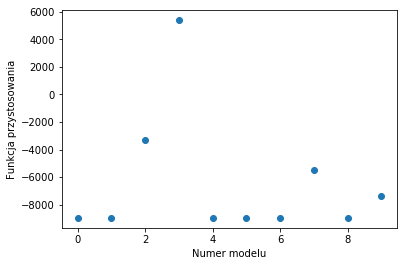

In [109]:
plt.scatter(list(range(0, 10)), f_fit[0])
plt.xlabel('Numer modelu')
plt.ylabel('Funkcja przystosowania')

In [145]:
k0 = pd.DataFrame
dfTP, dfFP, dfTN, dfFN = [], [], [], []
for i in klasyfikacja[0]:
    dfTN.append(klasyfikacja[0][i][0][0])
    dfFN.append(klasyfikacja[0][i][0][1])
    dfFP.append(klasyfikacja[0][i][1][0])
    dfTP.append(klasyfikacja[0][i][1][1])

In [146]:
k0 = pd.DataFrame([dfTN, dfFN, dfFP, dfTP])

In [147]:
print(k0)

       0      1      2      3      4      5      6      7      8      9
0  56122  56122  47175  45290  56122  56122  56122  55166  56122  55752
1      0      0   8947  10832      0      0      0    956      0    370
2    446    446    282     60    446    446    446    357    446    405
3      0      0    164    386      0      0      0     89      0     41


In [140]:
klasyfikacja[0][2]

array([[47175,  8947],
       [  282,   164]], dtype=int64)

In [135]:
klasyfikacja[0][0][1][0]

446

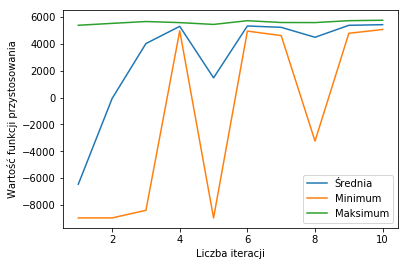

In [154]:
plt.plot(list(range(1, 11)), average_fitness, label='Średnia')
plt.plot(list(range(1, 11)), minimum_fitness, label='Minimum')
plt.plot(list(range(1, 11)), maximum_fitness, label='Maksimum')
plt.xlabel('Liczba iteracji')
plt.ylabel('Wartość funkcji przystosowania')
plt.legend()

In [23]:
best_chromosom = [3,   0, 392,   3,  22]
f_aktywacji = {1:'logistic', 2:'tanh', 3:'relu'}
wsp_uczenia = {0:'constant', 1:'invscaling'}    
best_warstwy = tuple(np.ones(best_chromosom[3], dtype=int)*best_chromosom[4])
final_mlp = MLPClassifier(hidden_layer_sizes=best_warstwy, activation=f_aktywacji[best_chromosom[0]],\
                        learning_rate=wsp_uczenia[best_chromosom[1]], solver='sgd', \
                          learning_rate_init = 1/(2*best_chromosom[2]), \
                          random_state=42)
final_mlp.fit(X_train_sc, Y_train)
final_prognoza = final_mlp.predict(X_test_sc)
final_macierz = confusion_matrix(Y_test, final_prognoza)


In [24]:
r2_score(Y_test, final_prognoza)

-22.053962036262128

In [25]:
print(final_macierz)

[[45985 10137]
 [   64   382]]


In [26]:
print(classification_report(Y_test, final_prognoza))

             precision    recall  f1-score   support

          0       1.00      0.82      0.90     56122
          1       0.04      0.86      0.07       446

avg / total       0.99      0.82      0.89     56568



In [80]:
from sklearn.metrics import roc_auc_score, roc_curve

In [86]:
roc_auc_score(Y_test, final_prognoza)
fpr, tpr, thresholds = roc_curve(Y_test, final_prognoza, pos_label=1)

In [87]:
fpr

array([ 0.        ,  0.18062435,  1.        ])

In [88]:
tpr

array([ 0.        ,  0.85650224,  1.        ])

In [79]:
roc_auc_score(Y_test, pred)

0.81881512777336629

In [31]:
final_w = np.array([final_macierz[1][1], final_macierz[0][1], final_macierz[0][0], final_macierz[1][0]])
funkcjaZysku(final_w)

5301.6999999999998

In [32]:
prob_prog = final_mlp.predict_proba(X_test_sc)

Gains Chart:

In [57]:
# siec
score = prob_prog[:, 1]
pos = pd.get_dummies(Y_test).as_matrix()[:, 1]
npos = np.sum(pos)
index = np.argsort(score)
index = index[::-1]
sort_pos=pos[index]
cpos = np.cumsum(sort_pos)
recall = cpos/npos
n = Y_test.shape[0]
random = np.arange(start=1, stop=n+1, step=1)
random = random/n

In [70]:
lr_pred_prob = linreg.predict_proba(X_test_sc)

In [71]:
# regresja
score2 = lr_pred_prob[:, 1]
index2 = np.argsort(score2)
index2 = index2[::-1]
sort_pos2 = pos[index2]
cpos = np.cumsum(sort_pos2)
recall2 = cpos/npos

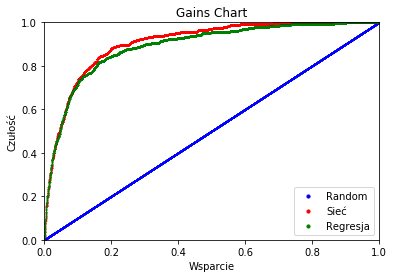

In [72]:
plt.title('Gains Chart')
plt.xlabel('Wsparcie')
plt.ylabel('Czułość')
plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(random, random, marker='.', color='blue', s=0.1)
plt.scatter(random, recall, marker='.', color='red', s=0.1)
plt.scatter(random, recall2, marker='.', color='green', s=0.1)
plt.legend(('Random', 'Sieć', 'Regresja'), markerscale=20)

In [65]:
?plt.legend

In [202]:
max(prob_prog[:,1])

0.99999999999999711

In [33]:
range(np.shape(prob_prog)[0])

range(0, 56568)

In [40]:
prob_prog

array([[ 0.64117417,  0.35882583],
       [ 0.98359912,  0.01640088],
       [ 0.40696616,  0.59303384],
       ..., 
       [ 0.13076667,  0.86923333],
       [ 0.99424019,  0.00575981],
       [ 0.94391609,  0.05608391]])

In [42]:
%matplotlib inline

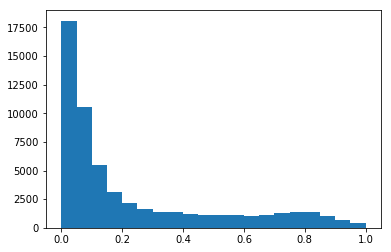

In [46]:
plt.hist(prob_prog[:, 1], bins = 20)
plt.show()

In [208]:
prob_prog_sorted = prob_prog[:, 1].sort()

In [171]:
final_mlp.coefs_[1]

array([[-0.21712122, -0.23324006, -0.02656915,  0.44395918, -0.27299334,
         0.36388413,  0.02121038, -0.29186023, -0.3442812 , -0.1276517 ,
         0.15946967, -0.33098294,  0.04755861,  0.23261608,  0.16130889,
        -0.33125724, -0.35123135, -0.27396393,  0.3745431 , -0.16252066,
        -0.05291469,  0.21880497],
       [ 0.04929124,  0.17480185, -0.28440869, -0.37636645,  0.31070505,
         0.10554802,  0.08591479,  0.1040808 ,  0.13905684,  0.28875574,
         0.11990177,  0.37115774,  0.12454246, -0.14842943, -0.22400251,
        -0.02942156,  0.15520178,  0.30512955, -0.37527208, -0.32008186,
        -0.22482279, -0.0939043 ],
       [-0.20644796, -0.00153526,  0.29497455, -0.1511691 ,  0.03042625,
        -0.28000651,  0.10065199, -0.0857047 , -0.11515922,  0.06542647,
         0.09239305, -0.02393263, -0.22956951,  0.01148735, -0.33464678,
         0.33951944, -0.32437664,  0.33514893, -0.13757996,  0.1977667 ,
        -0.29863876, -0.10373079],
       [-0.02291989

In [178]:
li = {}
lh = {}
ln = {}
for i in range(0, 10):
    lij = []
    lhj = []
    lnj = []
    for j in zb_pop[i]:
        lij.append(zb_pop[i][j][2])
        lhj.append(zb_pop[i][j][3])
        lnj.append(zb_pop[i][j][4])
    li[i] = lij
    lh[i] = lhj
    ln[i] = lnj

In [182]:
lh

{0: [4, 3, 3, 2, 3, 5, 3, 3, 4, 4],
 1: [3, 3, 3, 3, 3, 3, 3, 3, 2, 3],
 2: [3, 3, 3, 3, 2, 3, 3, 3, 3, 3],
 3: [3, 3, 3, 3, 2, 3, 3, 3, 3, 3],
 4: [3, 3, 5, 3, 3, 3, 3, 3, 3, 3],
 5: [3, 5, 3, 3, 3, 5, 5, 3, 3, 3],
 6: [5, 5, 3, 3, 3, 5, 3, 5, 3, 3],
 7: [3, 3, 3, 3, 3, 3, 5, 3, 5, 3],
 8: [3, 3, 3, 3, 3, 3, 3, 3, 5, 3],
 9: [3, 3, 3, 3, 3, 5, 3, 2, 4, 3]}

In [180]:
df_lh = pd.DataFrame(lh)

In [181]:
df_lh

,0,1,2,3,4,5,6,7,8,9
0,4,3,3,3,3,3,5,3,3,3
1,3,3,3,3,3,5,5,3,3,3
2,3,3,3,3,5,3,3,3,3,3
3,2,3,3,3,3,3,3,3,3,3
4,3,3,2,2,3,3,3,3,3,3
5,5,3,3,3,3,5,5,3,3,5
6,3,3,3,3,3,5,3,5,3,3
7,3,3,3,3,3,3,5,3,3,2
8,4,2,3,3,3,3,3,5,5,4
9,4,3,3,3,3,3,3,3,3,3


In [177]:
zb_pop[0]

{0: array([  1,   0, 985,   4,  21]),
 1: array([  1,   0, 970,   3,  54]),
 2: array([  3,   1, 753,   3,  81]),
 3: array([  3,   0, 392,   2,  22]),
 4: array([  1,   1, 895,   3,  11]),
 5: array([  1,   0, 469,   5,  90]),
 6: array([  1,   0, 512,   3,  98]),
 7: array([  3,   1, 711,   3,  44]),
 8: array([  1,   1, 126,   4, 103]),
 9: array([  3,   1, 335,   4, 114])}

In [22]:
def siec2(chromosom):
    '''
    
    Funkcja tworząca nową sieć na podstawie otrzymanego chromosomu
    Parametry:
     - chromosom
     
    Zwraca:
     - macierz - macierz błędu\trafności 
    
    '''
    f_aktywacji = {1:'logistic', 2:'tanh', 3:'relu'}
    wsp_uczenia = {0:'constant', 1:'invscaling'}
    warstwy = tuple(np.ones(chromosom[3], dtype=int)*chromosom[4])
    mlp = MLPClassifier(hidden_layer_sizes=warstwy, activation=f_aktywacji[chromosom[0]],\
                        learning_rate=wsp_uczenia[chromosom[1]], solver='sgd', learning_rate_init = 1/(2*chromosom[2])\
                        , random_state=42)
    
    mlp.fit(X_train_sc, Y_train)
    prognoza = mlp.predict(X_test_sc)
    macierz = confusion_matrix(Y_test, prognoza)
    r2 = r2_score(Y_test, prognoza)

    return r2, macierz

In [32]:
final_prognoza[:23]

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [33]:
Y_test[:23].values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [34]:
Y_test.value_counts()

0    56122
1      446
Name: event, dtype: int64

In [41]:
sum(final_prognoza)

10519